In [ ]:
!pip install chainer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967722 sha256=072b8d58f36048eb74f4f2d0e29f4f1a92a84d1620917552b6d7797ffd3b8b65
  Stored in directory: /root/.cache/pip/wheels/c4/95/6a/16014db6f761c4e742755b64aac60dbe142da1df6c5919f790
Successfully built chainer


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import pickle
from numpy import savetxt
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import confusion_matrix
from PIL import Image
from PIL import Image
import h5py
import torchvision
import torch.nn.functional as F
import pdb
from torch import nn
import math
from torch.optim import lr_scheduler
%matplotlib inline
from sklearn import metrics
import torch
import itertools
sns.set(style="darkgrid")
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.utils import make_grid
from tqdm import tqdm
from torchvision import models
import torch.optim as optim
import torchvision
from matplotlib.ticker import MaxNLocator
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import MaxPool2d
!pip install torchsummary
from torchsummary import summary
import chainer.links as L
from PIL import Image
import warnings
import h5py
warnings.filterwarnings("ignore")
plt.ion()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with h5py.File('drive/MyDrive/Deep_Learning_Project/train_capsule_data_images.h5', 'r') as hf:
    images = hf['images'][:]
    label_ids = hf['labels'][:]

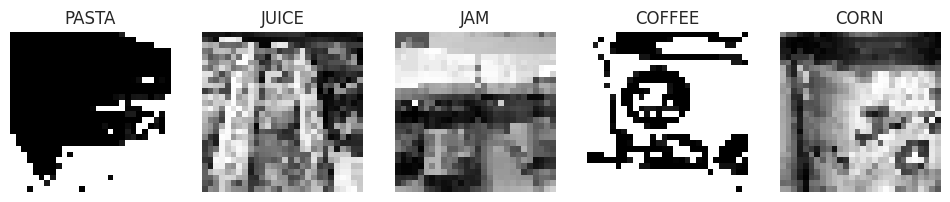

In [ ]:
class DatasetProcessing(Dataset):
    def __init__(self, images, labels, transform=None): 
        self.transform = transform
        self.data = images.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
        self.target = torch.from_numpy(labels).long()
    def __getitem__(self, index):
        return self.transform(self.data[index]), self.target[index]
    def __len__(self):
        return len(self.data)

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

# Verileri H5 dosyalarından yükleyin
with h5py.File('drive/MyDrive/Deep_Learning_Project/train_capsule_data_images.h5', 'r') as hf:
    train_images = hf['images'][:]
    train_labels = hf['labels'][:]
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels , test_size = .25, random_state = 1)

dset_train = DatasetProcessing(X_train, y_train, transform)
train_loader = torch.utils.data.DataLoader(dset_train, batch_size=32,
                                          shuffle=True, num_workers=4)

dset_test = DatasetProcessing(X_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=32,
                                         shuffle=True, num_workers=4)

classes = ['WATER', 
          'VINEGAR', 
          'TOMATO_SAUCE', 
          'TEA', 
          'SUGAR', 
          'SPICES', 
          'SODA', 
          'RICE',
          'PASTA', 
          'OIL', 
          'NUTS','MILK',
          'JUICE', 
          'JAM', 
          'HONEY', 
          'FLOUR',
          'FISH',
          'CORN',
          'COFFEE',
          'CHOCOLATE',
          'CHIPS',
          'CEREAL',
          'CANDY',
          'CAKE',
          'BEANS',
          ]

fig = plt.figure(figsize=(12,6))
for num, x in enumerate(train_images.reshape((-1,28,28))[0:5]):
    plt.subplot(1,5,num+1)
    plt.axis('off')
    plt.imshow(x, cmap='gray')
    plt.title(classes[train_labels[num]])


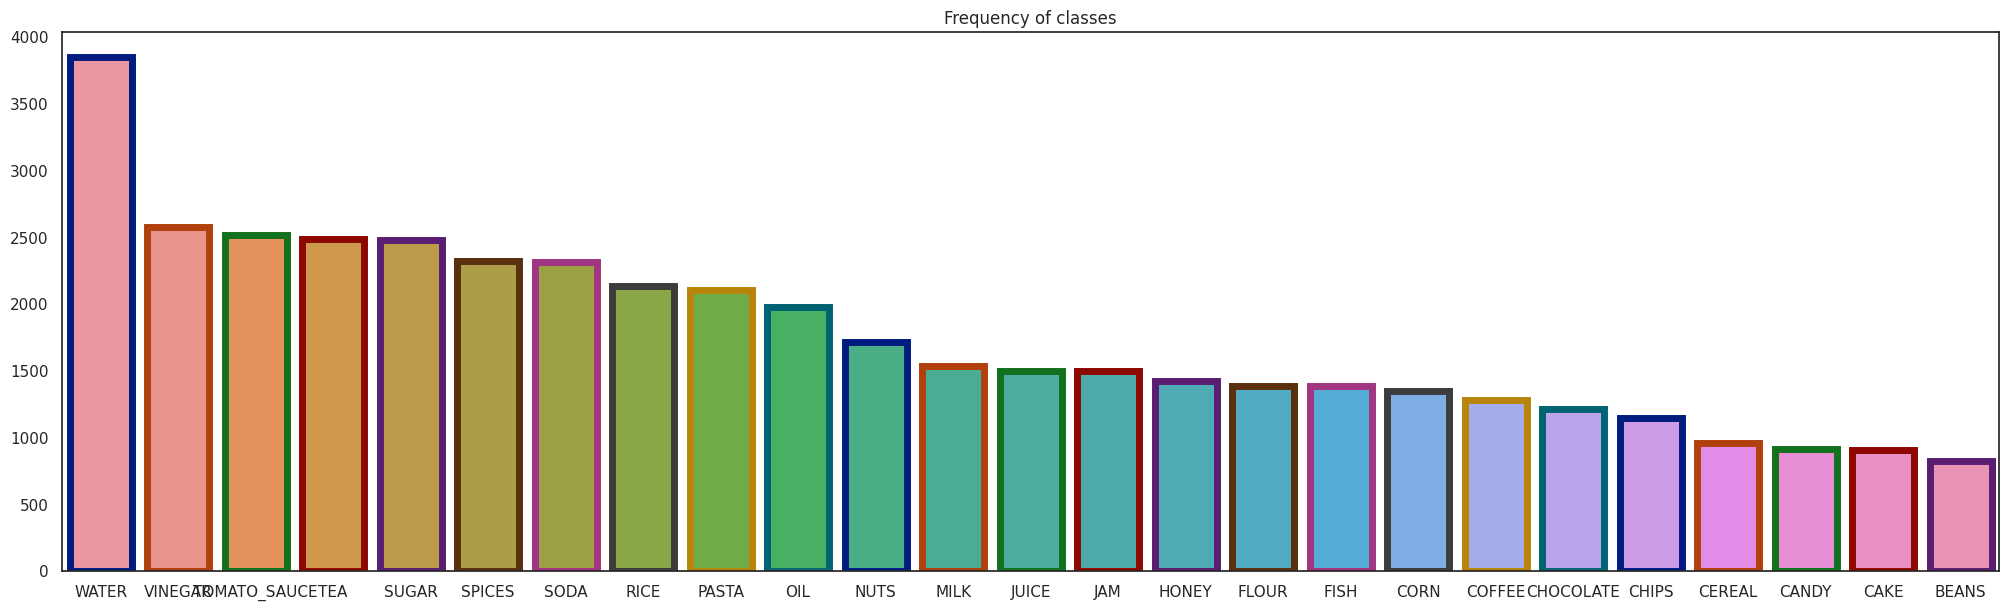

In [ ]:
fig = plt.figure(figsize=(25, 7))
sns.set_style("white")

# Calculate the frequency of each class in the training labels
class_counts = pd.value_counts(train_labels)

ax = sns.barplot(x=classes, y=class_counts, linewidth=5, edgecolor=sns.color_palette("dark", 10))
plt.title("Frequency of classes")
plt.show()

In [ ]:
class CapsuleLevel(nn.Module):
    def __init__(self, in_channels, out_channels, capsule_dimension = 8, num_capsules = 25, num_capsule_units = 6 * 6 * 32, routing = False, iterations=3):
        super(CapsuleLevel, self).__init__()
        self.routing = routing
        self.iterations = iterations
        self.num_capsules = num_capsules
        self.num_capsule_units = num_capsule_units
        if routing == True:
            self.route_weights = nn.Parameter(torch.randn(num_capsule_units, num_capsules, out_channels, in_channels))
        else:
            self.capsules = nn.ModuleList(
                [nn.Conv2d(in_channels, out_channels, kernel_size=(9, 9), stride=(2, 2), padding=0) for _ in
                 range(capsule_dimension)])

            
    # The squash function
    def squash(self, s, dim=-1):
        norm = torch.sum(s**2, dim=dim, keepdim=True)
        return norm / (1 + norm) * s / (torch.sqrt(norm) + 1e-8)

    def forward(self, x):
        if self.routing == True:          # Routing by Agreement
            batch_size = x.size(0)
            
            route_weights = torch.stack([self.route_weights] * batch_size, dim = 0) #dim:([1152, 10, 16, 8])
            x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4) #dim:([28, 1152, 10, 8, 1])
            u_hat = torch.matmul(self.route_weights, x)  #dim:([28, 1152, 10, 16, 1])
            u_hat = u_hat.squeeze(-1)   #dim([128, 1152, 10, 16])
            temp_u_hat = u_hat.detach()
            
            #b_ij dim:([128, 1152, 10, 1])
            b_ij = Variable(torch.zeros(batch_size, self.num_capsule_units, self.num_capsules, 1).cuda()) 
            for iteration in range(self.iterations):
                c_ij = F.softmax(b_ij, dim=1)   # Equation 1 # c_ij dim:([28, 1152, 10, 1])
                s_ij = (c_ij * temp_u_hat).sum(dim=1)  # Equation 2 # s_ij dim:([128, 10, 16])
                temp_u_hat = temp_u_hat.unsqueeze(3)  # temp_u_hat dim:([28, 1152, 10, 16, 1])
                v_j = self.squash(s_ij, dim=2) # Equation 3  # v_j dim:([28, 10, 16])
                v_j_i = torch.stack([v_j] * self.num_capsule_units, dim = 1).unsqueeze(-1) # v_j_i dim:([28, 10, 16, 1])
                v_j_i = torch.matmul(temp_u_hat, v_j_i).squeeze(3)  
                temp_u_hat = temp_u_hat.squeeze(3)
                b_ij = b_ij + v_j_i # Equation 4
        else:
            v_j = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]   
            v_j = torch.cat(v_j, dim=-1)
            v_j = self.squash(v_j)

        return v_j

In [ ]:
class CapsuleNetwork(nn.Module):  
    def __init__(self):
        super(CapsuleNetwork, self).__init__()
        self.batch_size = 128
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(9, 9), stride=(1, 1), padding=0)
        self.primaryCaps = CapsuleLevel(in_channels=256, out_channels=32, capsule_dimension=8)
        self.digitCaps   = CapsuleLevel(in_channels=8, out_channels=16, num_capsules=25, routing=True)
        self.decoder     = nn.Sequential(
            nn.Linear(16 * 25, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 784),
            nn.Sigmoid()
        )
    def forward(self, x, y=None):
        x = F.relu(self.conv1(x), inplace=True)
        x = self.primaryCaps(x)
        x = self.digitCaps(x)
        classes = (x ** 2).sum(dim=-1) ** 0.5
        classes = F.softmax(classes, dim=-1)
        if y is None:
            # Get most active capsule
            _, max_length_indices = classes.max(dim=1)
            y = Variable(torch.eye(25)).cuda().index_select(dim=0, index=Variable(max_length_indices.data))
        reconstructions = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return classes, reconstructions

In [ ]:
class LossFunction(nn.Module):
    def __init__(self):
        super(LossFunction, self).__init__()
        self.reconstruction_loss = nn.MSELoss(size_average=False)

    def forward(self, img, target, classes, reconstructions):
        fn_1 = F.relu(0.9 - classes, inplace=True) ** 2  # Calculated for correct digit cap
        fn_2 = F.relu(classes - 0.1, inplace=True) ** 2  # Calculated for incorrect digit cap
        margin_loss = target * fn_1 + 0.5 * (1. - target) * fn_2
        margin_loss = margin_loss.sum()
        img = img.view(reconstructions.size()[0], -1)
        reconstruction_loss = self.reconstruction_loss(reconstructions, img)
        return (margin_loss + 0.0005 * reconstruction_loss) / img.size(0)

In [ ]:
train_loss = []
test_loss = []
def train(train_loader, epoch):
    global model
    model.train()
    if torch.cuda.is_available():
        model = model.cuda()
    tr_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size(0)
        labels = target
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        capsule_loss = LossFunction()
        labels = torch.LongTensor(labels)
        labels = torch.eye(25).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        optimizer.zero_grad()
        classes, reconstructions = model(data, labels)
        loss = capsule_loss(data, labels, classes, reconstructions)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()
        pred = classes.data.max(1, keepdim=True)[1]
        if (batch_idx + 1)% 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item()))
    train_loss.append(tr_loss / len(train_loader))

In [ ]:
def evaluate(data_loader):
    global model
    model.eval()
    loss = 0
    
    for data, target in data_loader:
        labels = target
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        labels = torch.LongTensor(labels)
        labels = torch.eye(25).index_select(dim=0, index=labels)
        labels = Variable(labels).cuda()
        classes, reconstructions = model(data)
        capsule_loss = LossFunction()
        loss += capsule_loss(data, labels, classes, reconstructions).item()
        pred = classes.data.max(1, keepdim=True)[1]
        
    loss /= len(data_loader.dataset)
    test_loss.append(loss)
    print('\nAverage Validation loss: {:.6f}\n'.format(loss))

In [ ]:
summary(CapsuleNetwork().cuda(), input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 20, 20]          20,992
            Conv2d-2             [-1, 32, 6, 6]         663,584
            Conv2d-3             [-1, 32, 6, 6]         663,584
            Conv2d-4             [-1, 32, 6, 6]         663,584
            Conv2d-5             [-1, 32, 6, 6]         663,584
            Conv2d-6             [-1, 32, 6, 6]         663,584
            Conv2d-7             [-1, 32, 6, 6]         663,584
            Conv2d-8             [-1, 32, 6, 6]         663,584
            Conv2d-9             [-1, 32, 6, 6]         663,584
     CapsuleLevel-10              [-1, 1152, 8]               0
     CapsuleLevel-11               [-1, 25, 16]               0
           Linear-12                 [-1, 2048]         821,248
             ReLU-13                 [-1, 2048]               0
           Linear-14                 [-

In [ ]:
model = CapsuleNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.01)
n_epochs = 10
for epoch in range(n_epochs):
    train(train_loader, epoch)  #Training the model
    evaluate(test_loader)  #evaluating the model

Train Epoch: 0 [16000/32812 (49%)]	Loss: 1.170794
Train Epoch: 0 [32000/32812 (97%)]	Loss: 1.214080

Average Validation loss: 0.037922

Train Epoch: 1 [16000/32812 (49%)]	Loss: 1.238383
Train Epoch: 1 [32000/32812 (97%)]	Loss: 1.193512

Average Validation loss: 0.037923

Train Epoch: 2 [16000/32812 (49%)]	Loss: 1.231815
Train Epoch: 2 [32000/32812 (97%)]	Loss: 1.248633

Average Validation loss: 0.037922

Train Epoch: 3 [16000/32812 (49%)]	Loss: 1.173913
Train Epoch: 3 [32000/32812 (97%)]	Loss: 1.268865

Average Validation loss: 0.037922

Train Epoch: 4 [16000/32812 (49%)]	Loss: 1.244777
Train Epoch: 4 [32000/32812 (97%)]	Loss: 1.189523

Average Validation loss: 0.037922

Train Epoch: 5 [16000/32812 (49%)]	Loss: 1.142263
Train Epoch: 5 [32000/32812 (97%)]	Loss: 1.144216

Average Validation loss: 0.037922

Train Epoch: 6 [16000/32812 (49%)]	Loss: 1.215073
Train Epoch: 6 [32000/32812 (97%)]	Loss: 1.160020

Average Validation loss: 0.037923

Train Epoch: 7 [16000/32812 (49%)]	Loss: 1.25936

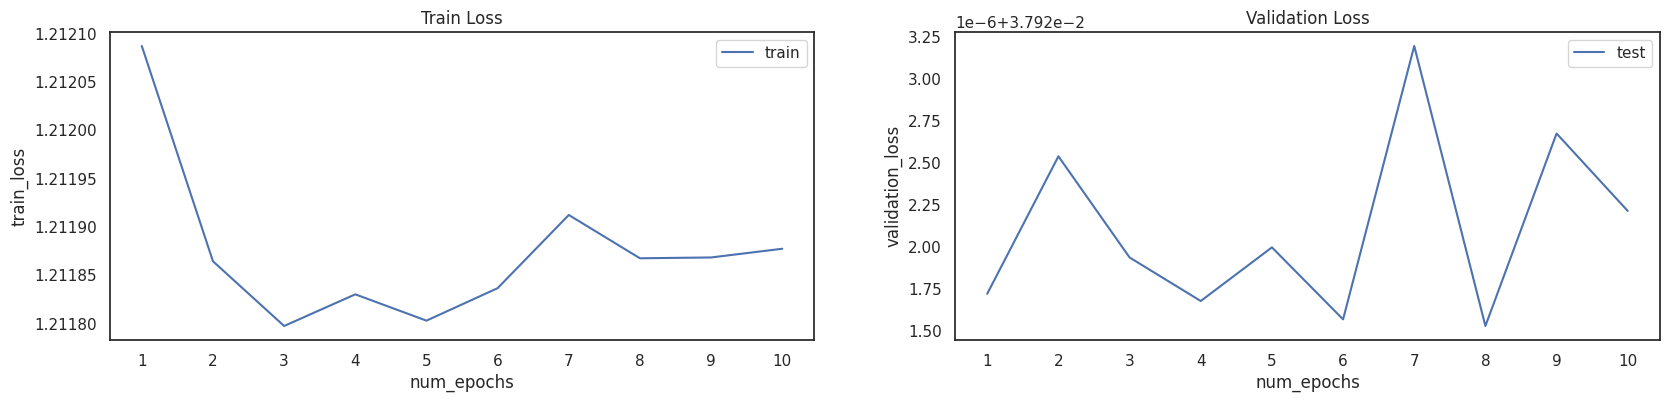

In [ ]:
num_epochs = min(len(train_loss), len(test_loss), 15)

fig = plt.figure(figsize=(20,4))

ax = fig.add_subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(list(np.arange(num_epochs) + 1) , train_loss[:num_epochs], label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('train_loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')

ax = fig.add_subplot(1, 2, 2)
plt.title("Validation Loss")
plt.plot(list(np.arange(num_epochs) + 1), test_loss[:num_epochs], label='test')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('validation_loss', fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(loc='best')


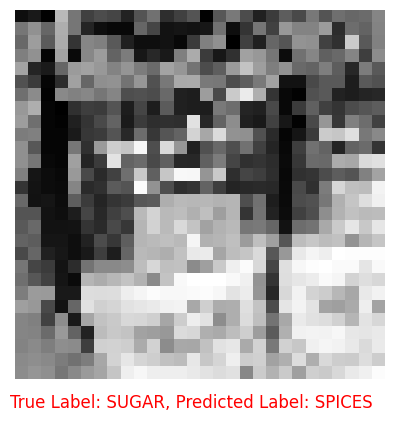

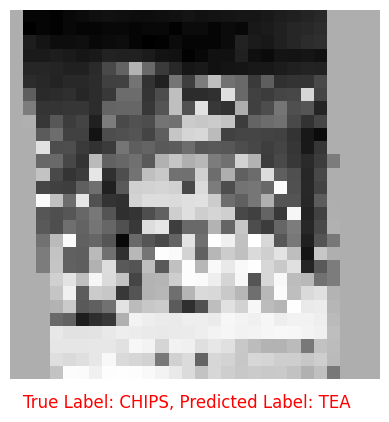

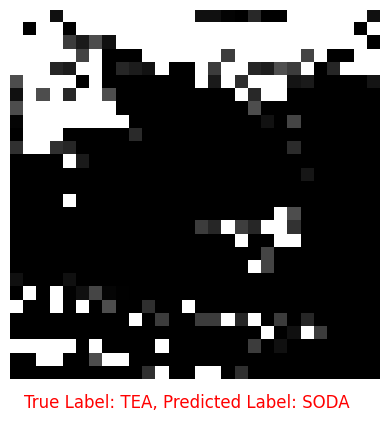

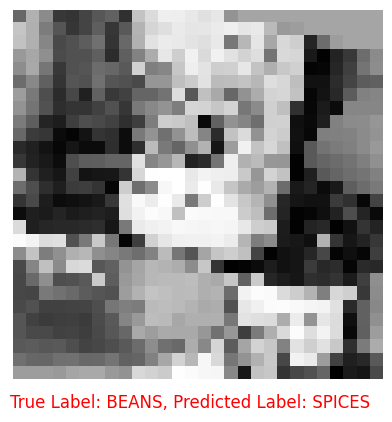

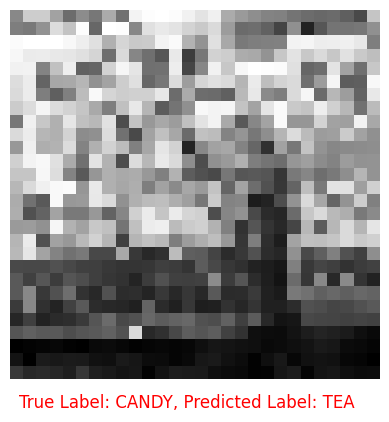

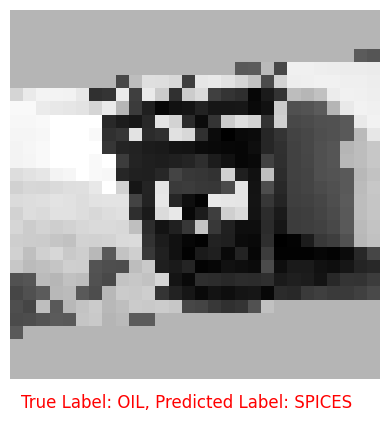

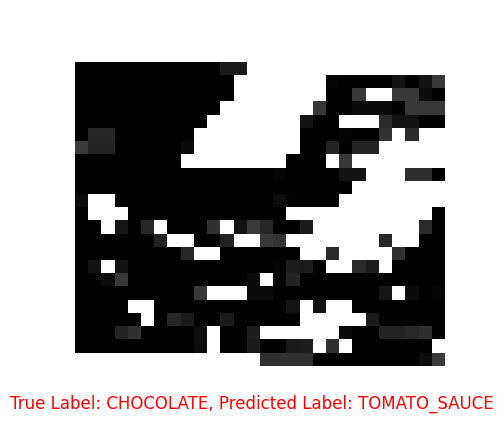

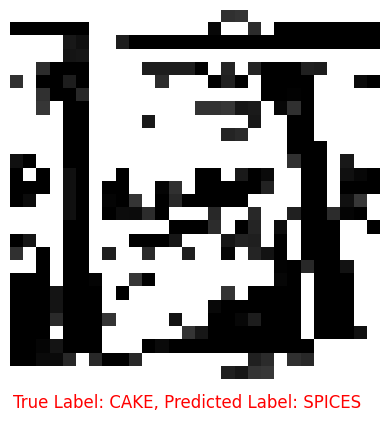

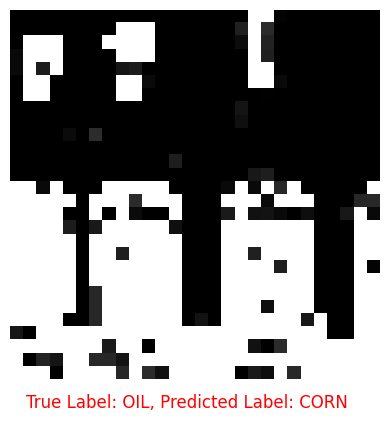

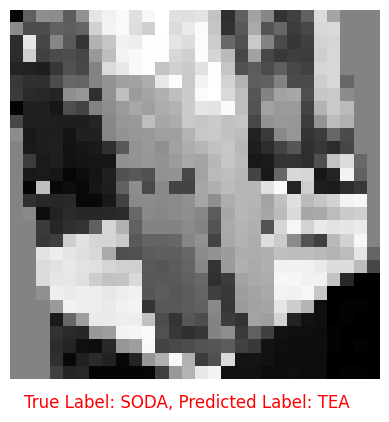

Accuracy: 0.00%


In [ ]:
import random

with h5py.File('drive/MyDrive/Deep_Learning_Project/test_capsule_data_images.h5', 'r') as hf:
    images = hf['images'][:]
    label_ids = hf['labels'][:]

# images'i düzleştirme
flattened_images = images.reshape(images.shape[0], -1)

# images ve label_ids'yi birleştirme
data = np.hstack((label_ids.reshape(-1, 1), flattened_images))

# DataFrame oluşturma
df_test = pd.DataFrame(data)

# Etiket sütununu adlandırma
df_test.rename(columns={0: "label"}, inplace=True)

# Assuming X_test and y_test are pandas DataFrames or Series
dset_test = DatasetProcessing(df_test.iloc[:, 1:].values, df_test['label'].values, transform)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=1,
                                          shuffle=True, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the test set
random_indices = random.sample(range(len(test_loader.dataset)), 10)

correct_predictions = 0

# Loop over the selected images and make predictions
for index in random_indices:
    image, label = test_loader.dataset[index]
    image = image.unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    
    # Forward pass to get the predicted class
    output, _ = model(image)
    _, predicted_class = output.max(dim=1)
    
    # Convert predicted class to class name
    predicted_class_index = predicted_class.item()
    predicted_class_name = classes[predicted_class_index]
    
    # Check if prediction is correct
    correct = predicted_class_index == label.item()
    if correct:
        correct_predictions += 1
    
    # Plot the image with color based on prediction correctness
    fig, ax = plt.subplots()
    ax.imshow(image.squeeze().cpu().numpy(), cmap='gray')
    ax.axis('off')

    color = "green" if correct else "red"
    fig.text(0.5, 0.05, f"True Label: {classes[label.item()]}, Predicted Label: {predicted_class_name}", ha='center', color=color)
    
    plt.show()


accuracy = correct_predictions / len(random_indices) * 100
print(f"Accuracy: {accuracy:.2f}%")